In [1]:
from __future__ import print_function
import os
import pickle
import json

from argparse import Namespace

import numpy
from data import get_test_loader
import time
import numpy as np
from vocab import Vocabulary  # NOQA
import torch
from model import VSE, order_sim
from collections import OrderedDict, Counter
import pandas as pd
import matplotlib.pyplot as plt

from evaluation import encode_data

In [2]:
args = Namespace(
    model_path="data/runs/coco_vse++_resnet_restval/model_best.pth.tar",
    image_path="/home/vu48pok/.data/compling/data/corpora/external/MSCOCO/COCO/val2014/",
    data_path="data/",
    vocab_path="vocab/",
    split="test",
    on_gpu=True
)

def eval_file(caption_file, cluster_file, args=args):
    device = 'cpu' if not args.on_gpu else 'cuda'
    checkpoint = torch.load(args.model_path, map_location=torch.device(device))
    opt = checkpoint['opt']
    #opt
    
    with open(caption_file) as f:
        data = json.load(f)
    img_ids = [i['image_id'] for i in data['annotations']]
    with open(cluster_file, 'rb') as f:
        clusters = pickle.load(f)
    assert [i[0] for i in clusters] == img_ids, 'image ids in caption and cluster files not identical'
    
    if args.data_path is not None:
        opt.data_path = args.data_path
    if args.vocab_path is not None:
        opt.vocab_path = args.vocab_path

    # load vocabulary used by the model
    with open(os.path.join(opt.vocab_path,
                           '%s_vocab.pkl' % opt.data_name), 'rb') as f:
        vocab = pickle.load(f)
    opt.vocab_size = len(vocab)

    # construct model
    model = VSE(opt)

    # load model state
    model.load_state_dict(checkpoint['model'])

    print('Loading dataset')
    data_loader = get_test_loader(args.split, opt.data_name, vocab, opt.crop_size,
                                  opt.batch_size, opt.workers, opt, 
                                  image_location=args.image_path,
                                  caption_file=caption_file
                                 )

    print('Computing embeddings...')
    img_embs, cap_embs = encode_data(model, data_loader, on_gpu=args.on_gpu)
    print('Images: %d, Captions: %d' %
          (img_embs.shape[0], cap_embs.shape[0]))
    
    
    ann_df = pd.DataFrame(data_loader.dataset.coco[0].anns).T.set_index('id')

    idx2imgid = ann_df['image_id'].to_dict()
    imgid2idx = {v: k for k, v in idx2imgid.items()}

    all_ranks = np.zeros((len(cap_embs), 3))

    for i in range(len(cap_embs)):
        cemb = cap_embs[i]
        target = ann_df.loc[i].image_id
        #distractors = ann_df.loc[i].distractors
        cluster = [j for j in clusters if j[0] == target][0]
        assert target == cluster[0]
        #idx_array = np.array([imgid2idx[j] for j in [target]+distractors])
        idx_array = np.array([imgid2idx[j] for j in cluster])
        iemb = img_embs[idx_array]

        dots = cemb @ iemb.T
        ranks = np.argsort(dots.ravel())[::-1]
        all_ranks[i] = ranks

    target_positions = np.where(all_ranks==0)[1]

    acc = len(target_positions[target_positions == 0]) / len(target_positions)
    
    print('\nresults:\n')
    
    print('file:', caption_file)
    counts = Counter(target_positions)
    keys = sorted(counts.keys())
    values = [counts[k] for k in keys]
    plt.bar(keys, values)
    plt.xticks(keys)
    plt.show()
    print('acc:', acc)

=> using pre-trained model 'resnet152'
Loading dataset
loading annotations into memory...
0:00:00.052739
creating index...
index created!
Computing embeddings...
Images: 5000, Captions: 5000

results:

file: caps_files/rsa50_caps.json


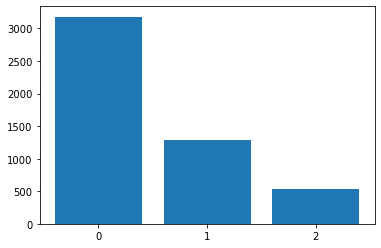

acc: 0.636


In [3]:
eval_file('caps_files/rsa50_caps.json', 'caps_files/image_clusters_val_3.pkl')

=> using pre-trained model 'resnet152'
Loading dataset
loading annotations into memory...
0:00:00.052521
creating index...
index created!
Computing embeddings...
Images: 5000, Captions: 5000

results:

file: caps_files/rsa05_caps.json


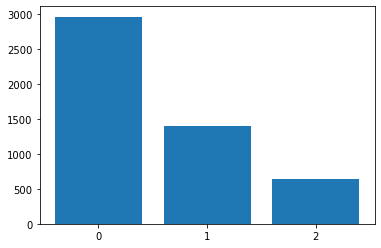

acc: 0.5926


In [4]:
eval_file('caps_files/rsa05_caps.json', 'caps_files/image_clusters_val_3.pkl')

=> using pre-trained model 'resnet152'
Loading dataset
loading annotations into memory...
0:00:00.052992
creating index...
index created!
Computing embeddings...
Images: 5000, Captions: 5000

results:

file: caps_files/beam_caps.json


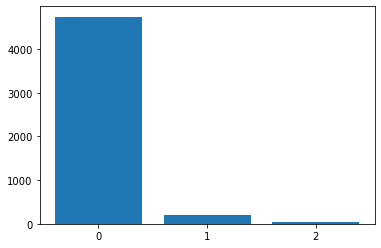

acc: 0.948


In [5]:
eval_file('caps_files/beam_caps.json', 'caps_files/image_clusters_val_3.pkl')

=> using pre-trained model 'resnet152'
Loading dataset
loading annotations into memory...
0:00:00.052927
creating index...
index created!
Computing embeddings...
Images: 5000, Captions: 5000

results:

file: caps_files/greedy_caps.json


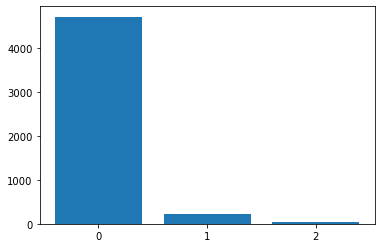

acc: 0.9448


In [6]:
eval_file('caps_files/greedy_caps.json', 'caps_files/image_clusters_val_3.pkl')